# Flopy Tutorial 1: Steady-State, Confined Aquifer 

This script will walk through the creation of a single-layer, confined aquifer in _flopy_ with _MODFLOW6_ to run a steady-state simulation of groundwater flow in a 100m x 100m domain with a 10m head boundary on one side and a 0m head boundary on the other side, as displayed below:

<img src="https://i.imgur.com/PH9sCDw.png" title="modflow model" width="600px" /></a>

If you're new to flopy, check out the documentation [here](https://github.com/modflowpy/flopy). It's an excellent resource for download instructions, all of the flopy commands, and examples of flopy code. The basis for this tutorial may be found here as well, with some further explanation/post-processing done in this jupyter notebook.

Using flopy, it is helpful to be familiar with MODFLOW. The online documentation is located here and will have additional information on the variables used in flopy functions: 

- Hughes, J.D., Langevin, C.D., and Banta, E.R., 2017, Documentation for the MODFLOW 6 framework: U.S. Geological Survey Techniques and Methods, book 6, chap. A57, 40 p., https://doi.org/10.3133/tm6A57.
- Langevin, C.D., Hughes, J.D., Banta, E.R., Niswonger, R.G., Panday, Sorab, and Provost, A.M., 2017, Documentation for the MODFLOW 6 Groundwater Flow Model: U.S. Geological Survey Techniques and Methods, book 6, chap. A55, 197 p., https://doi.org/10.3133/tm6A55.

<strong> Note:</strong> In order to use this script you must download a MODFLOW executable from the USGS website. (https://water.usgs.gov/ogw/modflow/) This script will only work with *MODFLOW6* executables.

References: This tutorial is based off the flopy documentation located here: http://modflowpy.github.io/flopydoc/ Bakker, M., Post, V., Langevin, C. D., Hughes, J. D., White, J. T., Starn, J. J. and Fienen, M. N., 2016, Scripting MODFLOW Model Development Using Python and FloPy: Groundwater, v. 54, p. 733–739, doi:10.1111/gwat.12413.

# Introduction
Flopy is a python package, developed to create and run MODFLOW groundwater flow models. The schematic below, illustrates how Flopy communicates with MODFLOW:

<img src="https://i.imgur.com/n2Dj6QF.png" title="Flopy to MODFLOW Flow Chart" /></a>

* <strong> <font size = 5> 1 </font> </strong> Aquifer properties are collected or estimated from some aquifer system, including dimensions, elevations, hydraulic conductivity, specific storage/yield and location/properties of wells, rivers, lakes or other hydrologic features. 

* <strong> <font size = 5> 2 </font> </strong> A model is created in a python script using the Flopy package to set up the different Packages MODFLOW uses to run its groundwater flow models, (GWF, NPF...), as python objects. 

* <strong> <font size = 5> 3 </font> </strong> Flopy is called to write the MODFLOW input files from these objects. 

* <strong> <font size = 5> 4 </font> </strong> A Flopy function sends the files to a specified MODFLOW executable program that will be used to solve the groundwater flow model. 

* <strong> <font size = 5> 5 </font> </strong> The MODFLOW executable program outputs binary data into head and budget files. 

* <strong> <font size = 5> 6 </font> </strong> Flopy reads in binary head and budget data from the MODFLOW output files.

* <strong> <font size = 5> 7 </font> </strong> Data is visualized using Flopy's plotting capabilities.        


<!-- ## Contents of script:

* <strong><a href="#I">I: Model Object </a></strong>


#### Creating MODFLOW Packages in Flopy:
* <strong><a href="#II">II: DIS Package</a> </strong> 
    <ul>
      <li> Discretizing time & space and setting up the MODFLOW DIS file.</li>  
        </ul>
    
* <strong><a href="#III">III: BAS Package</a> </strong>
    <ul>
      <li> Specifying cell activity and setting up the MODFLOW BAS file.</li>  
        </ul>
* <strong><a href="#IV">IV: LPF Package</a> </strong>
    <ul>
      <li> Defining model properties and setting up the MODFLOW LPF file.</li>  
        </ul>

* <strong><a href="#V">V: OC Package</a> </strong>
    <ul>
      <li> Specifying the data that the MODFLOW executable will record as output during the model run and setting up the MODFLOW OC package.</li>  
        </ul>

* <strong><a href="#VI">VI: PCG Package</a> </strong>
    <ul>
      <li> Assigning the pre-conditioned conjugate gradient solver to the groundwater flow model by setting up the MODFLOW PCG package.</li>  
        </ul>

#### Writing Files and Running Model:

* <strong><a href="#VII">VII: Write MODFLOW Input Files</a> </strong>
* <strong><a href="#VIII">VIII: Run MODFLOW executable</a> </strong>

#### Post Processing:
* <strong><a href="#IX">IX: Read MODFLOW output</a> </strong>
* <strong><a href="#X">X: Plot Results</a> </strong>
    </li>
<ol>
 -->


- First we will import the appropriate packages to run a modflow model in python and display the data

In [1]:
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp


#jupyter specific--included to show plots in notebook
%matplotlib inline 

<a id="I"></a>
 ## I. Create MFSimulation Object

- We define a Modflow simulation object using the following flopy function. 
- The arguments are telling object 'model' what the modelname is and where the MODFLOW .exe file is to use to run the model on your computer. 
- *You will have to modify the exe_name variable to direct flopy to the modflow executable file on your computer! *
- Note that the default model workspace is the location of your python notebook, so all MODFLOW files will be created there, but you may specify a different workspace if you'd like the files to be created somewhere else. 
- Check [the documentation](https://flopy.readthedocs.io/en/latest/source/flopy.mf6.modflow.mfsimulation.html) for more info

In [2]:
model_name = "my_model"              # <- same as before
workspace  = "./my_model_ws"         # where input & output will go

sim = flopy.mf6.MFSimulation(
    sim_name=model_name,
    sim_ws=workspace
)

## <a id="II">II. Spatial discretization</a>
Now add info about the temporal discretization: (number of stress periods, steady-state/transient model within a stress period, length of stress periods, and the number of time steps within stress periods). Specifically, we define a 100 x 100 unit model domain, and discretize this into 10 rows and columns. 

In [3]:
#assign discretization variables
Lx = 100.
Ly = 100.
ztop = 0.
zbot = -50.
nlay = 1
nrow = 10
ncol = 10
dx = Lx/ncol
dy = Ly/nrow
dz = (ztop - zbot) / nlay

<img src="https://i.imgur.com/Abaeeyo.png" title="discretization" /></a>

### Temporal Discretization

To discretize time, we must first specify how many stress periods are involved in this model. This is done through flopy's variable 'nper'. As we are solving a steady-state model, we will only specify 1 stress period.

In [4]:
# 2. Time-discretisation (TDIS)  ── one period, steady-state
time_discretization = flopy.mf6.ModflowTdis(sim)

### Attach solver, ground water flow (GWF), and discretization modules

In [5]:
#create flopy discretization object, length and time are meters (2) and days (4)

# 2. IMS solver (simple defaults)
ims = flopy.mf6.ModflowIms(sim, complexity="SIMPLE")

# 3. Ground-water-flow model container
gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name, save_flows=True)

# 4. Discretisation package (replaces ModflowDis)
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=dx,
    delc=dy,
    top=ztop,
    botm=zbot,
    length_units="METERS",        # replaces lenuni = 2
)

## Visualize the discretization

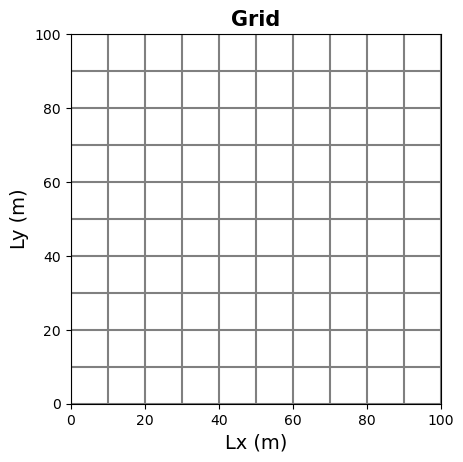

In [6]:
from flopy.plot import PlotMapView

# -- plot the structured grid of the MF6 model --------------------
map_view = PlotMapView(model=gwf, layer=0)   # gwf is the ModflowGwf object
map_view.plot_grid()

plt.xlabel("Lx (m)", fontsize=14)
plt.ylabel("Ly (m)", fontsize=14)
plt.title("Grid", fontsize=15, fontweight="bold")
plt.show()

## Specify constant head boundary conditions

In [7]:
# constant-head boundaries (left & right faces)
chd_cells = [((0, r, 0), 10.0) for r in range(nrow)] + \
            [((0, r, ncol - 1), 0.0) for r in range(nrow)]
flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chd_cells)

package_name = chd_0
filename = my_model.chd
package_type = chd
model_or_simulation_package = model
model_name = my_model

Block period
--------------------
stress_period_data
{internal}
(    cellid_layer  cellid_row  cellid_column  head
0              0           0              0  10.0
1              0           1              0  10.0
2              0           2              0  10.0
3              0           3              0  10.0
4              0           4              0  10.0
5              0           5              0  10.0
6              0           6              0  10.0
7              0           7              0  10.0
8              0           8              0  10.0
9              0           9              0  10.0
10             0           0              9   0.0
11             0           1              9   0.0
12             0           2              9   0.0
13             0           3              9   0.0
14             0           4              9   0.0
15          

### Define initial conditions (starting heads)
_strt_ is a 3-D NumPy array with shape (nlay, nrow, ncol) that supplies the initial head in every active cell at the start of the simulation.
In _FloPy_ the cells that hold a fixed head are specified in the ModflowGwfchd object.

- The values you place in strt for those CHD cells are effectively ignored once the model starts—they are immediately overwritten by the constant-head condition.

- For all other (active, non-CHD) cells, strt provides the initial guess for the solver (useful for transient problems) or the starting value that will be iterated to steady state.

In this model we want a steady-state flow field driven by:

- Left boundary: h = 10 m

- Right boundary: h = 0 m

In [8]:
# starting heads (interior = 1 m, left = 10 m, right = 0 m)
strt = np.ones((nlay, nrow, ncol), dtype=float)
strt[:, :, 0]  = 10.0
strt[:, :, -1] = 0.0
flopy.mf6.ModflowGwfic(gwf, strt=strt)

print("starting head values: \n", strt)

starting head values: 
 [[[10.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
  [10.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
  [10.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
  [10.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
  [10.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
  [10.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
  [10.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
  [10.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
  [10.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
  [10.  1.  1.  1.  1.  1.  1.  1.  1.  0.]]]


 <a name="IV"></a> 
## Specify aquifer properties using NPF (Node Property Flow)

The NPF package specifies Layer Properties associated with the flow in each cell. It holds information regarding horizontal and vertical hydraulic conductivity, layer confinement properties (confined/unconfined), specific storage, and specific yield among other flags for the model run for  which we will use flopy's default settings.

### Define Hydraulic Conductivity

Here we define "hk" as a variable for horizontal hydraulic conductivity of 1 m/d that will be the same in the x and y directions, and "vka" as a variable for vertical conductivity of 1 m/d. hk and vka are arrays of floats of form (nlay, nrow, ncol) with conductivity values for each cell. You may also specify a ratio of anisotropy in the y direction for the flopy LPF function, if hk should be anisotropic in the xy plane.


In [9]:
#define horizontal hydraulic conductivity
hk = np.ones((nlay,nrow,ncol), dtype=np.float32)
vk = np.ones((nlay,nrow,ncol), dtype=np.float32)

print("horizontal k values: \n", hk,
     "\n vertical k values: \n", vk)

horizontal k values: 
 [[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]] 
 vertical k values: 
 [[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]]


### Define Specific Storage
Specific storage is defined in a similar format to hydraulic conductivity with a value of $1 x 10^{-5} m^{-1}$ for each cell.

In [10]:
#define specific storage
ss = np.ones((nlay,nrow,ncol), dtype=float)
ss[:,:,:] = 1e-5

print("specific storage values: \n", ss)

specific storage values: 
 [[[1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
  [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
  [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
  [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
  [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
  [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
  [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
  [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
  [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
  [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]]]


### Define Aquifer Confinement Properties

Layers may be specified in flopy with variable <strong> laytyp </strong>, an array of (nlay) integer flags to say whether a model is:

- <strong> =0 Confined:</strong>  Aquifer layers will be treated as confined
- <strong> >0 Convertible:</strong> Aquifer layers will be treated as confined if the water level is above the top of the aquifer cell and unconfined if the water level is below the top of the aquifer cell.

This single-layer model will be treated as confined.

In [11]:
#define layer type as confined
laytyp = np.zeros((nlay,), dtype=np.int32)

print("layer type values: \n", laytyp)

layer type values: 
 [0]


In [12]:
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    icelltype=laytyp,   # 0 = confined, 1 = convertible (same flags you used before)
    k=hk,               # horizontal hydraulic conductivity
    k33=vk,             # vertical hydraulic conductivity (vka)
    save_specific_discharge=True,
)

## Write the model files

In [13]:
# Define output file names
budget_output_file = model_name + '.bud'
head_output_file = model_name + '.hds'

# Output control package for saving head and budget data
output_control = flopy.mf6.ModflowGwfoc(gwf,
                                        budget_filerecord=budget_output_file,
                                        head_filerecord=head_output_file,
                                        saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

# Write the simulation input files
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model my_model...
    writing model name file...
    writing package dis...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 20 based on size of stress_period_data
    writing package ic...
    writing package npf...
    writing package oc...


Flopy should have created 6 new files in your working directory that look something like:

<img src="https://i.imgur.com/AjODHeO.png" title="modflow_files" /></a>

The file to pay attention to is the "my_model.nam" file. This file governs which packages will be attached to your MODFLOW file. Inside the name file it will list all the packages to be attached to your model as well as specify that BINARY DATA files that it will write as an output. (my_model.hds, my_model.cbc)

<img src="https://i.imgur.com/8KOHV9T.png" title="nam_file" /></a>

Another file to pay attention to, post run, is the LIST file. This will have additional information on how the packages are attached to your model as well as MODFLOW mass-balance budgets during the model run. 

 <a name="VIII"></a> 
## Run MODFLOW Model

We can now run the MODFLOW model with the packages specified in the .nam file using the executable specified in the definition of our flopy model 'm':

In [14]:
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../opt/mf6.6.2_mac/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.2 05/12/2025

   MODFLOW 6 compiled May 12 2025 12:41:59 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S.

(True, [])

If the run was successful, you should have seen a window reporting *"Normal termination of simulation."* and the run time data. 

 <a name="IX"></a> 
## Read Head/Flow Data

In [15]:
# Retrieve the head and budget data from the simulation output

head_data = gwf.output.head().get_data()
budget_data = gwf.output.budget()

This head object has different attributes that can be extracted from it such as the times used in the model run, head data, databytes and more. For information on how to access these functions see: http://modflowpy.github.io/flopydoc/binaryfile.html

For this model, we will extract the head data after our single stress period (totim=1.0).

### Read Flow Data

In [16]:
# Extract specific discharge data from the budget output
specific_discharge_data = budget_data.get_data(text='DATA-SPDIS')[0]

# Extract individual components of specific discharge (qx, qy, qz)
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(specific_discharge_data, gwf)

 <a name="X"></a> 
## Plotting

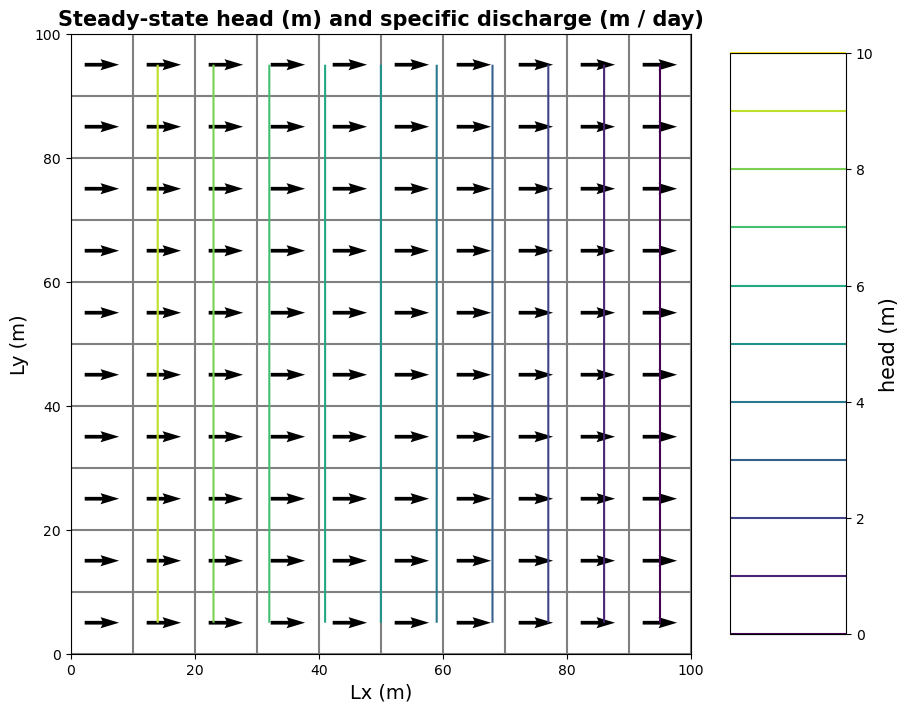

In [17]:
# 2-D arrays for the first (only) layer
h  = head_data[0]   # heads
qx0, qy0 = qx[0], qy[0]   # specific-discharge components

plt.figure(figsize=(10, 10))
map_view = PlotMapView(model=gwf, layer=0)
map_view.plot_grid()

# head contours
contours = np.linspace(h.min(), h.max(), 11)
head_cs  = map_view.contour_array(h, levels=contours)

# discharge arrows
map_view.plot_vector(qx0, qy0, normalize=True)

# labels & legend
plt.xlabel("Lx (m)", fontsize=14)
plt.ylabel("Ly (m)", fontsize=14)
plt.title("Steady-state head (m) and specific discharge (m / day)", 
          fontsize=15, fontweight="bold")
plt.colorbar(head_cs, aspect=5).set_label("head (m)", fontsize=15)
plt.show()

### 3D Surface Plot 

<strong> Note: </strong> This is not part of flopy's plotting, and uses a matplotlib function from a 3d projection toolkit. Flopy takes cell indexing where the top left of the grid is the (0,0) cell index while the Length & Width units start at 0 in the lower left of the grid. This seems a little wierd, but it makes it easy to match up an array of cell by cell numbers to their respective locations on the grid when assigning properties or observing output data. Flopy's plotting functions automatically flip the resultant head data to display on its proper grid, however, for the 3d plots below, you'll see the function np.flipud() is used to flip the data array to plot in the same direction.

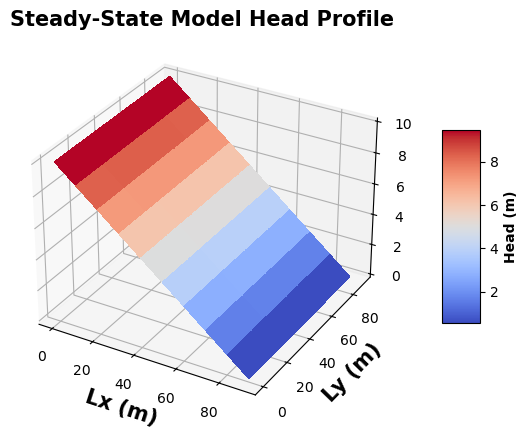

In [20]:
#import 3d axes toolkit from matplotlib
from mpl_toolkits.mplot3d import Axes3D

#create 3d figure
fig_3d = plt.figure(figsize=(12,5))
ax = fig_3d.add_subplot(projection='3d')

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
Z = np.flipud(head_data[0])

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = plt.cm.coolwarm, linewidth=0, antialiased=False, label='head')
fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title('Steady-State Model Head Profile', fontsize=15, fontweight='bold')
plt.show(surf)

Congratulations! You just used flopy to run a single-layer, steady-state model in MODFLOW-2005! 

<strong>Activity:</strong> Try going back to where we defined the starting heads in the LPF package and changing the left and right boundary conditions. How does the head surface change?

What happens if you add another row of constant head cells to the model by modifying the IBOUND variable and set those to a different value of starting heads?